# ASAS-SN-J06000 Light Curve Analysis

M Kenworthy kenworthy@strw.leidenuniv.nl // Leiden Observatory

2019 Dec 13

Astronomers telegram http://www.astronomerstelegram.org/?read=13346 reports an unusual dimming star ASASSN-V J060000.76-310027.83.

No dimming for 2200 days, then it is dipping with increasing drop over 0.25 mags over 1 day.

Eric Mamajek tweet on it: https://twitter.com/EricMamajek/status/1205229364037570561

This looks like a completely normal, negligibly reddened ~K5.5 dwarf. Low velocity and spot on solar main sequence => thin disk. 3D velocity no where near nearby very young clusters/associations, so unlikely to be <100 Myr. #GaiaDR2 Teff and luminosity appear to be spot on.


ASASSN-V J060000.76-310027.83 (position from Gaia DR2, source_id=2891196718939580672, d=156 pc, L=0.14 L_sun, T_eff=4270 K)

In [9]:
import numpy as np
from astropy import constants as c
from astropy import units as u
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

@u.quantity_input
def atoP(a:u.au, m1:u.M_sun, m2:u.M_jup)->u.year:
    """
    Calculate period from orbital radius and masses

    Args:
        a: semi-major axis
        m1, m2: Primary and secondary masses

    Returns:
        P: orbital period

    >>> import astropy.units as u
    >>> atoP(1.*u.au, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 0.99954192 yr>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)

    const = c.G/(4.*np.pi*np.pi)

    mu = m1 + m2

    P2 = np.power(a,3.)/(const*mu)

    P = np.power(P2, 0.5)
    return P

@u.quantity_input
def Ptoa(P:u.year, m1:u.M_sun, m2:u.M_jup)->u.au:
    """calculate orbital radius from period

    Args:
        P: orbital period
        m1, m2: Primary and secondary masses

    Returns:
        a: semi-major axis

    >>> import astropy.units as u
    >>> Ptoa(11.86*u.year, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 5.20222482 AU>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)
    const = c.G / (4.*np.pi*np.pi)
    mu = m1 + m2
    a3 = P*P*const*mu
    aa = np.power(a3, 1./3.)
    
    return aa

@u.quantity_input
def rhill(m1: u.Msun, m2: u.Mjup, a: u.au)->u.au:
    """
    Hill radius of the secondary m2 orbiting around m1
    
    Args:
        m1, m2: primary and secondary masses
        a: distance between m1 and m2

    Returns:
        rhill: radius of Hill sphere of m2

    >>> import astropy.units as u
    >>> rhill(1.0 * u.M_sun, 1.0 * u.M_jup, 5.2 * u.au)
    <Quantity 0.35489325 AU>
    """

    mu = m2 / (m1 + m2)
    rh = a * np.power(mu/3., 1./3.)
    return rh

## First impressions

Okay, let's have an overview of the data by plotting it warts and all:

Text(0, 0.5, 'Flux [mJy]')

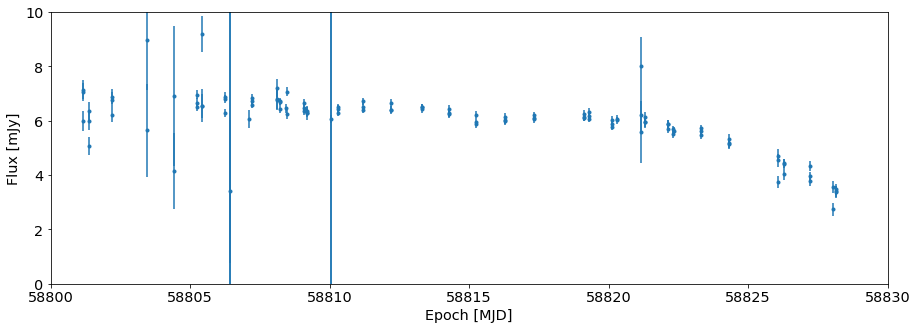

In [10]:

from astropy.io import ascii
t = ascii.read('light_curve_b4508c12-b04a-467c-9e20-6881885cf0fb.csv')
t['MJD'] = t['HJD']-2400000.5

plt.errorbar(t['MJD'],t['flux(mJy)'],yerr=t['flux_err'], fmt='.')
plt.xlim(58800,58830)
plt.ylim(0,10)
plt.xlabel('Epoch [MJD]')
plt.ylabel('Flux [mJy]')

So, lots of bad points with high r.m.s. We'll make a histogram of the r.m.s. noise and pull out the good photometry:

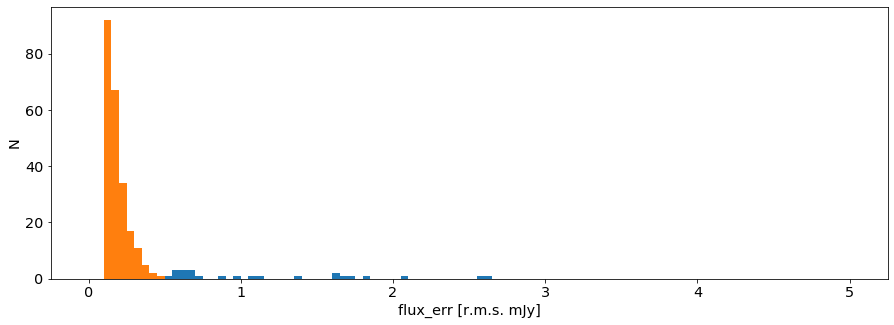

In [11]:
# make histogram of errors to see good and bad points

plt.hist(t['flux_err'],bins=100, range=(0,5));
plt.xlabel('flux_err [r.m.s. mJy]')
plt.ylabel('N')

# reject points with noise > 0.5 mJy
noise_rej = 0.5

s = t[t['flux_err']<noise_rej]

plt.hist(s['flux_err'],bins=100, range=(0,5));


## Normalise the light curve

Plot out the whole light curve, select points outside of the eclipse and calculate the mean out of eclipse flux:

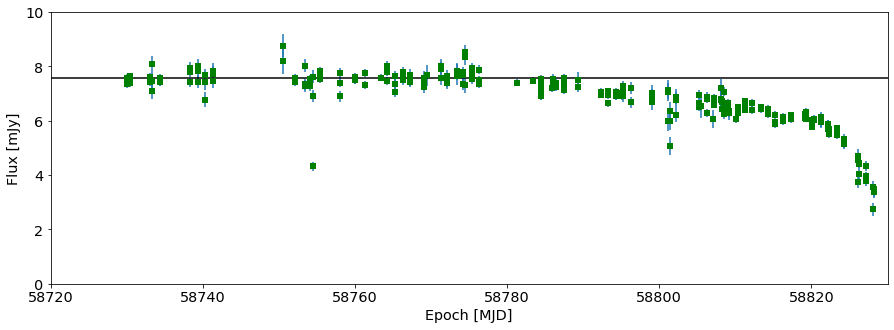

In [12]:
plt.errorbar(s['MJD'],s['flux(mJy)'],yerr=s['flux_err'],marker='s', mfc='red',
                 mec='green', ms=2, mew=4, fmt='.')
plt.xlim(58720,58830)
plt.ylim(0,10)
plt.xlabel('Epoch [MJD]')
plt.ylabel('Flux [mJy]')

# continuum points in the light curve
con = s[s['MJD']<58780]
mean_flux = con['flux(mJy)'].mean()

plt.hlines(mean_flux,58600,58830);

## Measure the steepest gradient of light curve

WIth the normalised flux light curve, fit a straight line to the steepest part and determine the gradient.

rate of change of light curve is -0.053 $L_*/d$


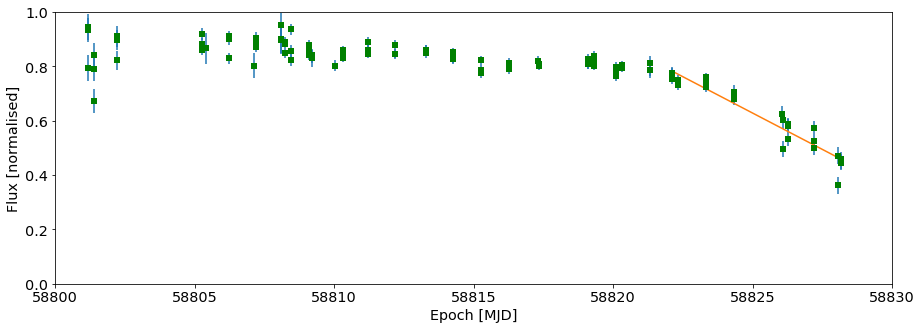

In [13]:
plt.errorbar(s['MJD'],s['flux(mJy)']/mean_flux,yerr=s['flux_err']/mean_flux,marker='s', mfc='red',
                 mec='green', ms=2, mew=4, fmt='.')
plt.xlim(58800,58830)
plt.ylim(0,1)
plt.xlabel('Epoch [MJD]')
plt.ylabel('Flux [normalised]')

# select all points in the steepest part of the light curve
slo = s[s['MJD']>58822]

mean_t = s['MJD'].mean()

# fit a straight line to the steepest part of the light curve
z = np.polyfit(slo['MJD']-mean_t, slo['flux(mJy)']/mean_flux, 1)

p = np.poly1d(z)

plt.plot(slo['MJD'],p(slo['MJD']-mean_t))

lc_gradient = z[0]
print('rate of change of light curve is {:.3f} $L_*/d$'.format(lc_gradient))

### Properties of the star

Taken from Eric Mamajek's tweets:

https://twitter.com/EricMamajek/status/1205272591855828992

Getting mass of 0.651 +- 0.025 Msun from @amannastro's 2018 calibration for absolute Ks magnitude (M_Ks=4.632; ignoring negligible reddening at K-band). Getting similar numbers from calibrations for eclipsing binaries (~0.67-0.68 Msun).

https://twitter.com/EricMamajek/status/1205246271889403904

For the new ASSN star that is dimming, I'm getting preliminary values of
Teff = 4410+-50K (photometric from BVJHKs photometry only, assumes solar metallicity), 
logL = -0.863+-0.015 dex, 
radius = 0.634+-0.018 Rsun. 
GaiaDR2 lists radius = 0.69 (0.64-0.71) Rsun.

In [14]:
r_star = 0.63 * u.Rsun
m_star = 0.65 * u.Msun

t_eclipse = 45 * u.day # half of the eclipse, eyeballing it...

Calculate the transverse velocity of a knife edge crossing the star using [van Werkhoven (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.441.2845V/abstract):    

In [15]:
v = 13 * (u.km / u.s) * -lc_gradient * (r_star/(1.13*u.Rsun))
print('transverse ring edge velocity is {:.2f}'.format(v))

transverse ring edge velocity is 0.39 km / s


What's the orbital distance for this velocity (again using [van Werkhoven (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.441.2845V/abstract)), and how big is the object assuming $v.t_{eclipse}$ ?

In [16]:
a_occulter = 8.0 * u.au * m_star / (0.9*u.Msun) * np.power(v/(10.*(u.km/u.s)),-2)
print('Orbital distance for the derived velocity: {:.0f}'.format(a_occulter.to(u.au)))
r_object = (v * t_eclipse).to(u.au)

print('Radius of the occulting object given the derived velocity: {:.3f}'.format(r_object))
print('Radius of the occulting object given the derived velocity: {:.3f}'.format(r_object.to(u.km)))

Orbital distance for the derived velocity: 3846 AU
Radius of the occulting object given the derived velocity: 0.010 AU
Radius of the occulting object given the derived velocity: 1507024.924 km


## Conclusions

The light curve has a gradient of about $0.02 L_\odot/d$, corresponding to an orbital distance of over 3000AU, and a derived diameter of about 0.01 AU or about 1.5 million km. Could be a ring system, or a disk around a substellar object or low mass star. It will be interesting to see where this goes. 